Using Athena version 20.7.3.8, on /afs/cern.ch/user/m/mazhang/eos/atlas/user/m/mazhang/Data/xAOD/VertexingXAODttbar/XAOD.pileupTruth.ttbar.pool.root.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
datafile = "../Data/TrackAssociation/20160502.txt"
data = np.loadtxt(datafile, delimiter="\t", skiprows=1) #first row is branch names

In [5]:
branch_names = open(datafile).readline().rstrip().split(",")
branch_names = [c.strip() for c in branch_names]

In [6]:
y = np.array([row[branch_names.index("correctVtx")] for row in data])
X = np.delete(data, branch_names.index("correctVtx"), 1)
branch_names.pop(branch_names.index("correctVtx"));
X = np.delete(X, branch_names.index("truVtxX"), 1)
branch_names.pop(branch_names.index("truVtxX"));
X = np.delete(X, branch_names.index("truVtxY"), 1)
branch_names.pop(branch_names.index("truVtxY"));
X = np.delete(X, branch_names.index("truVtxZ"), 1)
branch_names.pop(branch_names.index("truVtxZ"));

In [8]:
print(y.size)
print(sum(y))

53485
46385.0


In [10]:
from sklearn.cross_validation import train_test_split

X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.25)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=492)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=0.01*len(X_train))
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_samples_leaf=320.91, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [12]:
y_predicted = bdt.predict(X_test)
print (classification_report(y_test, y_predicted, target_names=["false trk/vtx match", "true trk/vtx match"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

                     precision    recall  f1-score   support

false trk/vtx match       0.67      0.31      0.42      1428
 true trk/vtx match       0.90      0.98      0.94      9269

        avg / total       0.87      0.89      0.87     10697

Area under ROC curve: 0.8607


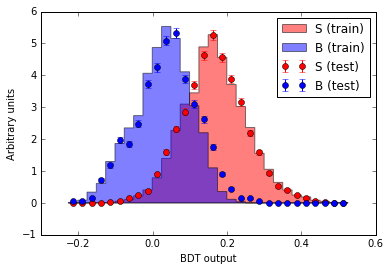

In [13]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='S (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='B (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)

PT = predicted true; AF = actual false
PT & AT: 9057
PF & AT: 212
PT & AF: 988
PF & AF: 440


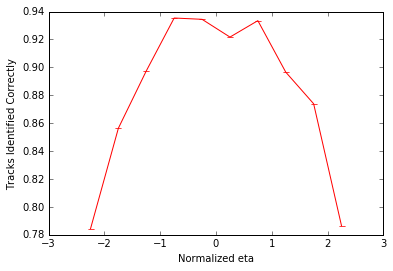

[ 0.78431373  0.85643564  0.89748045  0.93540268  0.93446809  0.92173913
  0.93350831  0.89661017  0.87394068  0.78644068]


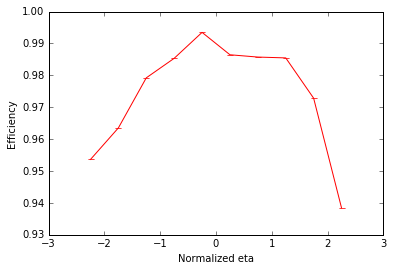

[ 0.95363215  0.96352941  0.97922849  0.98534799  0.99348231  0.98646035
  0.98574144  0.98547919  0.97283951  0.93843844]


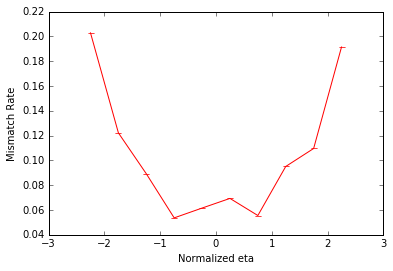

[ 0.20284238  0.1221865   0.08923643  0.05364996  0.06156552  0.06934307
  0.05555556  0.09511111  0.10960452  0.19146184]


In [14]:
y_predicted = np.round(y_predicted)
correctPrediction = 1*np.equal(y_predicted, y_test)
actualTrue = np.array(y_test==1)
actualFalse = np.array(y_test==0)
predictedTrue = np.array(y_predicted==1)
predictedFalse = np.array(y_predicted==0)

print("PT = predicted true; AF = actual false")
print("PT & AT:", sum(np.multiply(predictedTrue, actualTrue)))
print("PF & AT:", sum(np.multiply(predictedFalse, actualTrue)))
print("PT & AF:", sum(np.multiply(predictedTrue, actualFalse)))
print("PF & AF:", sum(np.multiply(predictedFalse, actualFalse)))

eta = X_test[:,branch_names.index("eta")]
nbins = 10

#tracks % identified correctly
n, _ = np.histogram(eta, bins=nbins)
sy, _ = np.histogram(eta, bins=nbins, weights=correctPrediction)
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Tracks Identified Correctly")
plt.show()
print(mean)

#efficiency = % identified as true out of all actual true
n, _ = np.histogram(eta[actualTrue], bins=nbins)
sy, _ = np.histogram(eta[actualTrue], bins=nbins, weights=1*predictedTrue[actualTrue])
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Efficiency")
plt.show()
print(mean)

#mismatch rate = % actual false out of those identified as true
n, _ = np.histogram(eta[predictedTrue], bins=nbins)
sy, _ = np.histogram(eta[predictedTrue], bins=nbins, weights=1*actualFalse[predictedTrue])
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Mismatch Rate")
plt.show()
print(mean)

                     precision    recall  f1-score   support

false trk/vtx match       0.57      0.16      0.25      1045
 true trk/vtx match       0.91      0.99      0.95      8897

        avg / total       0.87      0.90      0.87      9942

Area under ROC curve: 0.8309


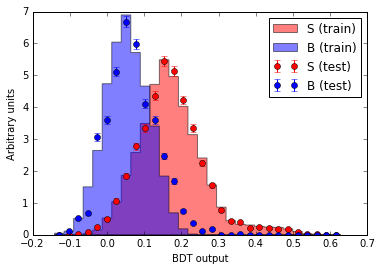

PT = predicted true; AF = actual false
PT & AT: 8771
PF & AT: 126
PT & AF: 876
PF & AF: 169


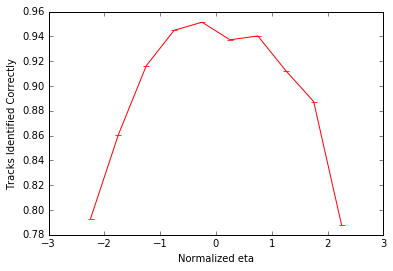

[ 0.79289216  0.8607864   0.91635338  0.94494585  0.95142071  0.93726236
  0.94035415  0.91240876  0.8875      0.78806334]


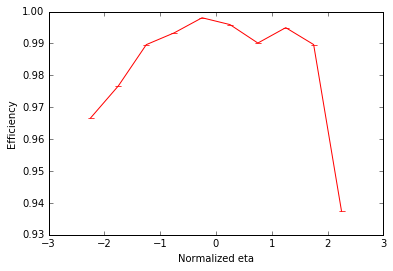

[ 0.96661367  0.97671569  0.98963731  0.99333333  0.99806763  0.99592668
  0.99013807  0.99496475  0.98966408  0.93740219]


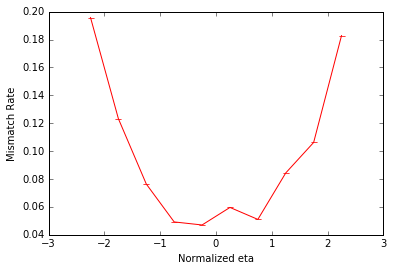

[ 0.1957672   0.12321232  0.07640232  0.04922516  0.04704797  0.05961538
  0.0510397   0.08433735  0.10618436  0.18281037]


In [15]:
# I realized that getting rid of the unmatched tracks was essentially the same as getting rid of low weights. That's why this split doesn't do very much.

#split into high and low weight
w = branch_names.index("trkWeight")
X_train_lowWeight = X_train[abs(X_train[:,w])<0.5]
X_train_highWeight = X_train[abs(X_train[:,w])>0.5]
y_train_lowWeight = y_train[abs(X_train[:,w])<0.5]
y_train_highWeight = y_train[abs(X_train[:,w])>0.5]
X_test_lowWeight = X_test[abs(X_test[:,w])<0.5]
X_test_highWeight = X_test[abs(X_test[:,w])>0.5]
y_test_lowWeight = y_test[abs(X_test[:,w])<0.5]
y_test_highWeight = y_test[abs(X_test[:,w])>0.5]

X_new_train = X_train_highWeight
y_new_train = y_train_highWeight
X_new_test = X_test_highWeight
y_new_test = y_test_highWeight

#repeat everything
bdt.fit(X_new_train, y_new_train)
y_new_predicted = bdt.predict(X_new_test)
print (classification_report(y_new_test, y_new_predicted, target_names=["false trk/vtx match", "true trk/vtx match"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_new_test, bdt.decision_function(X_new_test))))

compare_train_test(bdt, X_new_train, y_new_train, X_new_test, y_new_test)
plt.show()

y_new_predicted = np.round(y_new_predicted)
correctPrediction = 1*np.equal(y_new_predicted, y_new_test)
actualTrue = np.array(y_new_test==1)
actualFalse = np.array(y_new_test==0)
predictedTrue = np.array(y_new_predicted==1)
predictedFalse = np.array(y_new_predicted==0)

print("PT = predicted true; AF = actual false")
print("PT & AT:", sum(np.multiply(predictedTrue, actualTrue)))
print("PF & AT:", sum(np.multiply(predictedFalse, actualTrue)))
print("PT & AF:", sum(np.multiply(predictedTrue, actualFalse)))
print("PF & AF:", sum(np.multiply(predictedFalse, actualFalse)))

eta = X_new_test[:,branch_names.index("eta")]
nbins = 10

#tracks % identified correctly
n, _ = np.histogram(eta, bins=nbins)
sy, _ = np.histogram(eta, bins=nbins, weights=correctPrediction)
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Tracks Identified Correctly")
plt.show()
print(mean)

#efficiency = % identified as true out of all actual true
n, _ = np.histogram(eta[actualTrue], bins=nbins)
sy, _ = np.histogram(eta[actualTrue], bins=nbins, weights=1*predictedTrue[actualTrue])
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Efficiency")
plt.show()
print(mean)

#mismatch rate = % actual false out of those identified as true
n, _ = np.histogram(eta[predictedTrue], bins=nbins)
sy, _ = np.histogram(eta[predictedTrue], bins=nbins, weights=1*actualFalse[predictedTrue])
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Mismatch Rate")
plt.show()
print(mean)